In [1]:
from itertools import islice

from matplotlib import pyplot as plt
import matplotlib.dates as mdates

import torch
from gluonts.evaluation import make_evaluation_predictions, Evaluator
from gluonts.dataset.repository.datasets import get_dataset

from gluonts.dataset.pandas import PandasDataset
import pandas as pd

from gluonts.dataset.common import ListDataset
from sklearn.model_selection import train_test_split

from lag_llama.gluon.estimator import LagLlamaEstimator
from datasets import load_dataset

#RAF
from data_time_utils import find_best_matches_full_series_batch, augment_time_series, normalize_context, denormalize_predictions

/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/torch/cuda/__init__.py:654: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda:0')
print(device)

cuda:0


In [3]:
ckpt = torch.load("./lag-llama-model/lag-llama.ckpt", map_location=device)
estimator_args = ckpt["hyper_parameters"]["model_kwargs"]

def generate_lag_llama_forecasts(
    dataset,
    prediction_length,
    context_length=32,
    use_rope_scaling=False,
    num_samples=100,
    augment=False,
    top_n=1,
    device=device,
):

    # Menyiapkan argumen untuk RoPE scaling jika diperlukan
    rope_scaling_arguments = {
        "type": "linear",
        "factor": max(1.0, (context_length + prediction_length) / estimator_args["context_length"]),
    } if use_rope_scaling else None

    # Inisialisasi estimator Lag-Llama
    estimator = LagLlamaEstimator(
        ckpt_path="./lag-llama-model/lag-llama.ckpt",
        prediction_length=prediction_length,
        context_length=context_length,
        input_size=estimator_args["input_size"],
        n_layer=estimator_args["n_layer"],
        n_embd_per_head=estimator_args["n_embd_per_head"],
        n_head=estimator_args["n_head"],
        scaling=estimator_args["scaling"],
        time_feat=estimator_args["time_feat"],
        rope_scaling=rope_scaling_arguments,
        batch_size=1,
        num_parallel_samples=num_samples,
        device=device,
    )

    # Membuat modul Lightning dan transformasi
    lightning_module = estimator.create_lightning_module()
    transformation = estimator.create_transformation()
    predictor = estimator.create_predictor(transformation, lightning_module)

    # Menyiapkan data untuk prediksi
    context_tensor_matrix = [torch.tensor(entry["target"], dtype=torch.float32) for entry in dataset]

    if augment:
        # Proses augmentasi menggunakan RAF
        context_tensor_matrix, mean_std_values = augment_time_series(
            dataset, context_tensor_matrix, prediction_length, top_n
        )
        print('context_tensor_matrix:', context_tensor_matrix)
        print('mean_std_values:', mean_std_values)
    else:
        # Normalisasi konteks tanpa augmentasi
        context_tensor_matrix, mean_std_values = normalize_context(context_tensor_matrix)
        
    evaluation_dataset = [
        {
            "start": entry["start"],
            "target": context_tensor.numpy(),
        }
        for entry, context_tensor in zip(dataset, context_tensor_matrix)
    ]

    # Melakukan prediksi
    forecast_it, ts_it = make_evaluation_predictions(
        dataset=evaluation_dataset,
        predictor=predictor,
        num_samples=num_samples,
    )

    forecasts = list(forecast_it)
    tss = list(ts_it)

    # Denormalisasi hasil prediksi jika diperlukan
    if augment:
        forecasts = denormalize_predictions(forecasts, mean_std_values)
        print(forecasts)

    return forecasts, tss


/tmp/ipykernel_1051243/1638233653.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load("./lag-llama-model/lag-llama.ckpt", map_location=device)
/home/abizar

In [4]:
prediction_length = 20
context_length = 75

# Exchange Rate w/ RAF

In [5]:
dataset_er = get_dataset("exchange_rate")

/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/lightning/fabric/utilities/cloud_io.py:56: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
/home/abizard/miniconda3/envs/f

context_tensor_matrix: [tensor([-3.7594, -3.8151, -2.7400,  ...,  1.9922,  2.0361,  2.0190]), tensor([-3.9475, -3.9749, -1.9875,  ..., -0.4516, -0.4356, -0.4337]), tensor([-2.9889, -3.0524, -1.6592,  ...,  1.5376,  1.5791,  1.5716]), tensor([-2.7722, -1.8403, -0.1780,  ...,  1.7675,  1.8090,  1.8111]), tensor([5.4154, 5.0428, 5.4763,  ..., 0.8468, 0.8488, 0.8490]), tensor([-1.3241, -2.3922, -1.1863,  ...,  1.8973,  1.9107,  1.8569]), tensor([-3.5073, -3.9189, -3.2817,  ...,  1.7080,  1.7596,  1.7288]), tensor([-3.9181, -3.5670, -2.2136,  ...,  2.2318,  2.2629,  2.2567]), tensor([-2.1463, -2.1809, -2.4401,  ...,  2.0620,  2.0200,  2.0093]), tensor([-0.6417, -0.2216, -0.6109,  ..., -0.2115, -0.2758, -0.2721]), tensor([-1.2306, -1.5302, -1.8765,  ...,  1.6313,  1.5801,  1.5891]), tensor([-1.6278, -1.6071, -1.0457,  ...,  2.0013,  1.9686,  1.9811]), tensor([-0.1794,  0.2943, -0.5401,  ...,  0.8488,  0.8514,  0.8482]), tensor([1.7136, 1.7079, 1.0566,  ..., 1.5964, 1.6168, 1.6066]), tensor([

/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/dataset/split.py:181: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  sliced_entry[FieldName.START] += offset
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/transform/feature.py:364: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  index = pd.period_range(start, periods=length, freq=start.freq)
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/transform/feature.py:364: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  index = pd.period_range(start, periods=length, freq=start.freq)
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/transform/split.py:150: FutureWarning: Pe

[gluonts.model.forecast.SampleForecast(info=None, item_id=None, samples=array([[1.0266582 , 1.0203543 , 1.0245646 , 1.0216527 , 1.030621  ,
        1.0362333 , 1.0365782 , 1.0370388 , 1.0102665 , 1.0140305 ,
        1.0114625 , 1.003896  , 0.9991516 , 0.9950025 , 1.0216055 ,
        1.0325087 , 1.0232307 , 1.0302958 , 1.0187204 , 0.9671774 ],
       [1.0316787 , 1.0310574 , 1.0239234 , 1.0284106 , 1.0258427 ,
        1.0262527 , 1.0325587 , 1.0297694 , 1.028943  , 1.0334628 ,
        1.0391979 , 1.028273  , 1.062836  , 1.0377326 , 1.0500654 ,
        1.0399134 , 1.0456169 , 1.044354  , 1.0332781 , 1.0535278 ],
       [1.031059  , 1.0255407 , 1.0200602 , 1.0091484 , 1.0296884 ,
        1.0232241 , 1.0184714 , 1.0825409 , 1.0027565 , 1.0169144 ,
        1.0259404 , 1.0382574 , 1.0278103 , 1.0248103 , 1.0191945 ,
        1.0320435 , 1.0294203 , 1.0508369 , 1.0298108 , 1.0308769 ],
       [1.0325089 , 1.0672505 , 1.0424156 , 1.0245101 , 1.0419494 ,
        1.0441577 , 1.0368049 , 1.0320877

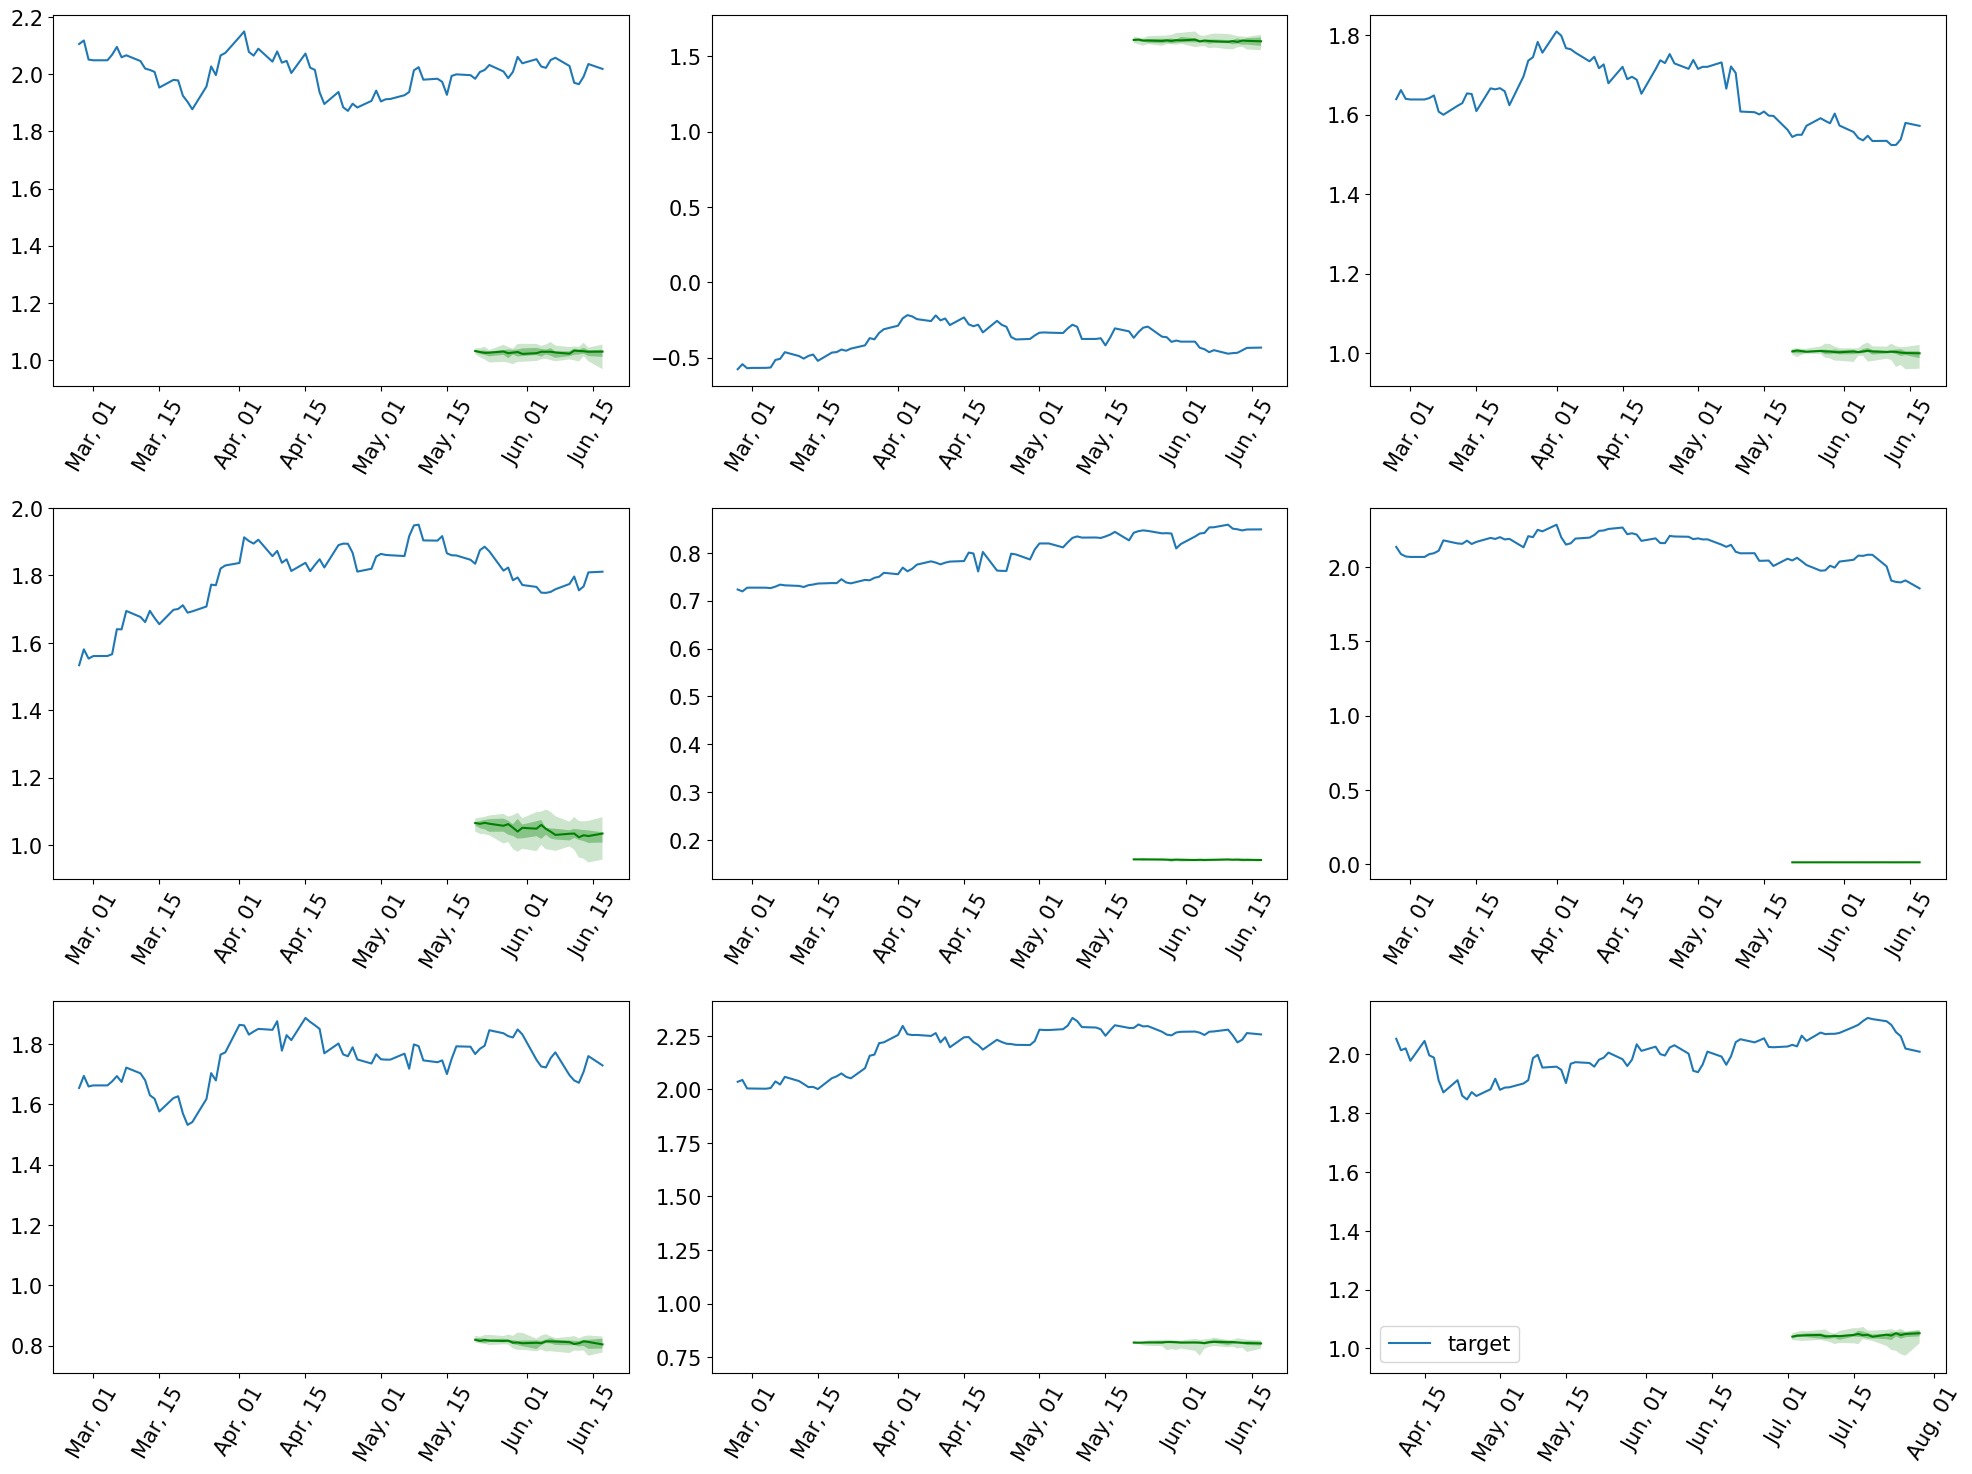

Running evaluation: 40it [00:00, 726.41it/s]


CRPS: 0.720290379402977
WQL: 1.0060371856729224
MSE: 1.446826131939888
MAPE: 1.1045588451623918
RMSE: 1.202840858941817
MASE: 21.962851980443325


/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/site-packages/gluonts/json.py:101: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/multiprocessing/queues.py:389: FutureWarning: PeriodDtype[B] is deprecated and will be removed in a future version. Use a DatetimeIndex with freq='B' instead
  return _ForkingPickler.loads(res)
/home/abizard/miniconda3/envs/finetuning/lib/python3.12/multiprocessing/queues.py:389: FutureWarning: Period with BDay freq is deprecated and will be removed in a future version. Use a DatetimeIndex with BDay freq instead.
  return _ForkingPickle

In [6]:
forecasts_it, tss_it= generate_lag_llama_forecasts(dataset_er.test, context_length = context_length, prediction_length= prediction_length, device = device, num_samples = 20, augment = True, use_rope_scaling=True)

plt.figure(figsize=(20, 15))
date_formater = mdates.DateFormatter("%b, %d")
plt.rcParams.update({"font.size": 15})

# iterate through the series, plot the predicted samples
for idx, (forecast, ts) in islice(enumerate(zip(forecasts_it, tss_it)), 9):
    ax = plt.subplot(3, 3, idx + 1)

    plt.plot(
        ts[(-4 * prediction_length):].to_timestamp(),
        label="target",
    )
    forecast.plot(color="g")
    plt.xticks(rotation=60)
    ax.xaxis.set_major_formatter(date_formater)
    ax.set_title(forecast.item_id)

plt.gcf().tight_layout()
plt.legend()
plt.show()

evaluator = Evaluator()
agg_metrics, ts_metrics = evaluator(iter(tss_it), iter(forecasts_it))
print('CRPS:', agg_metrics['mean_wQuantileLoss'])
print('WQL:', agg_metrics['wQuantileLoss[0.9]'])
print('MSE:', agg_metrics['MSE'])
print('MAPE:', agg_metrics['MAPE'])
print('RMSE:', agg_metrics['RMSE'])
print('MASE:', agg_metrics['MASE'])